Tom Barclay's xoflares on EPIC-246301900

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.3.3
1.0.5
3.9.3
1.11.2


In [3]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

"\nlc = search.search_targetpixelfile('EPIC 246301900').download()\nlc.to_lightcurve().plot()\nref_time = 0.5 * (lc.time.min() + lc.time.max())\n"

In [4]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

'lc = lc.to_lightcurve()\nprint(lc.flux.shape)\n'

In [3]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [4]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [20]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

3255


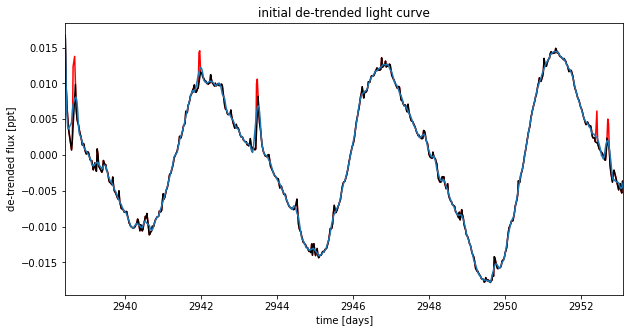

In [22]:
# get a smoothed version of the light curve
norm_y = normalize_flux(post.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 13, polyorder=3)
resid = norm_y - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(post.TIME, norm_y, "r")
plt.plot(post.TIME[mask], norm_y[mask], "k")
plt.plot(post.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
#plt.ylim(580000, 680000)
plt.xlim(post.TIME.min(), post.TIME.max());

In [42]:
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(post)

/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

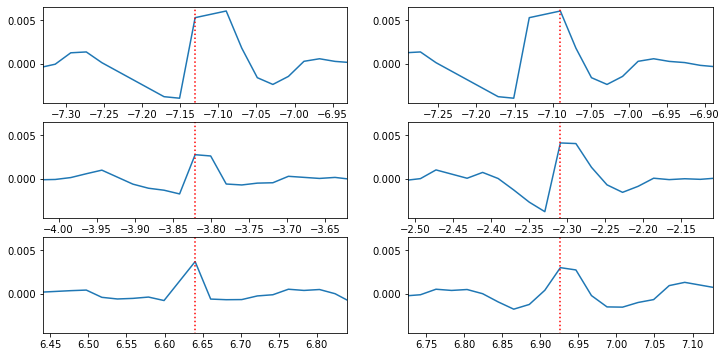

In [43]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

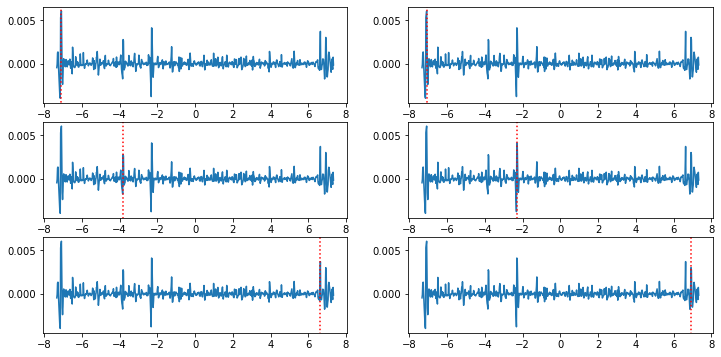

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')


In [46]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [47]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.816427071198394e+21 -> -1.7401127742777889e+21
optimizing logp for variables: [mean, logAmpl]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.7401127742777889e+21 -> -1.7382746455099724e+21
optimizing logp for variables: [logAmpl, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.7382746455099724e+21 -> -1.732977885879393e+21
optimizing logp for variables: [tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.732977885879393e+21 -> -1.732977885879393e+21


Finished [100%]: Average Loss = -3,981.5
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = -3,981.5


In [48]:
start[0]['tpeak'] - 0.2

array([-7.33032316, -7.29148626, -4.02384302, -2.50564819,  6.43878574,
        6.72712491])

/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '

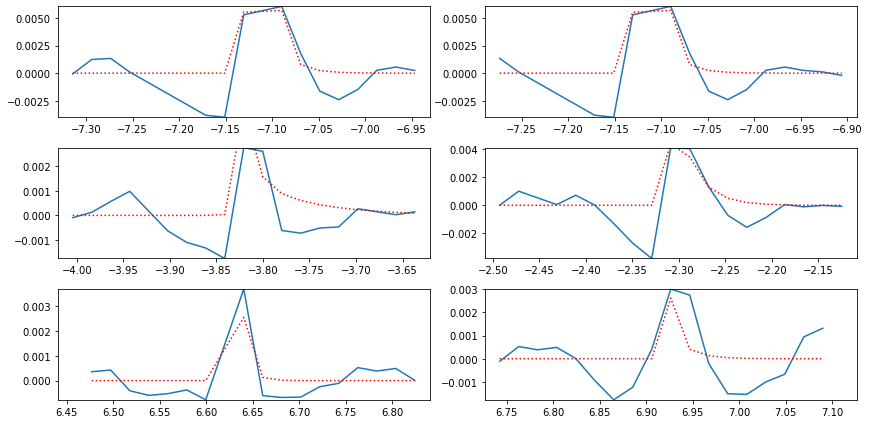

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [50]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [51]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
INFO:pymc3:NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 4336 seconds.
INFO:pymc3:Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 4336 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [52]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

/Users/chris/anaconda2/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/chris/anaconda2/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],-4.652,0.501,-5.392,-3.717,0.011,0.008,1996.0,1996.0,2425.0,2483.0,1.00
logAmpl[1],-4.366,0.554,-5.247,-3.370,0.015,0.010,1456.0,1456.0,1685.0,1955.0,1.00
logAmpl[2],-4.556,0.833,-5.952,-3.125,0.023,0.016,1348.0,1283.0,1441.0,4749.0,1.00
logAmpl[3],-3.319,0.386,-4.056,-2.599,0.008,0.006,2193.0,2130.0,2232.0,2672.0,1.00
logAmpl[4],-4.988,0.539,-5.797,-3.917,0.009,0.007,3323.0,3323.0,3902.0,3782.0,1.00
logAmpl[5],-3.912,0.732,-5.530,-2.732,0.020,0.015,1350.0,1230.0,1542.0,1543.0,1.00
logFwhm[0],-5.727,0.679,-7.029,-4.592,0.011,0.008,3972.0,3817.0,4370.0,4597.0,1.00
logFwhm[1],-5.776,0.405,-6.526,-5.051,0.006,0.005,4090.0,3924.0,4581.0,3751.0,1.00
logFwhm[2],-5.126,0.531,-5.990,-4.099,0.012,0.008,1998.0,1998.0,2244.0,4997.0,1.00
logFwhm[3],-5.388,0.245,-5.866,-4.945,0.005,0.004,2099.0,2099.0,2189.0,2312.0,1.00


In [59]:
tpeaks = np.delete(tpeaks, 1)

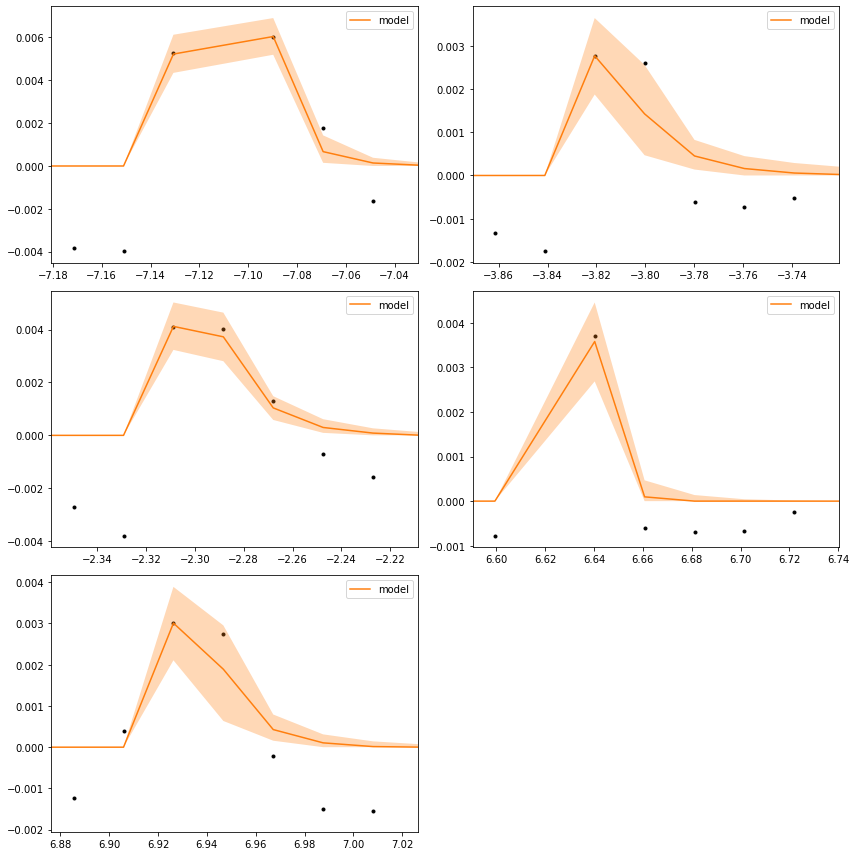

In [61]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks-1): # cause we double counted one
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.delaxes(axes[5])
fig.tight_layout()
fig.savefig('flare-model-postflare-pregap.png')

In [62]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

In [63]:
#print(samples.head())
#print(trace['tpeak'].shape[1])
#print(['tpeak__{}'.format(i), 'ampl__{}'.format(i), 'fwhm__{}'.format(i)])

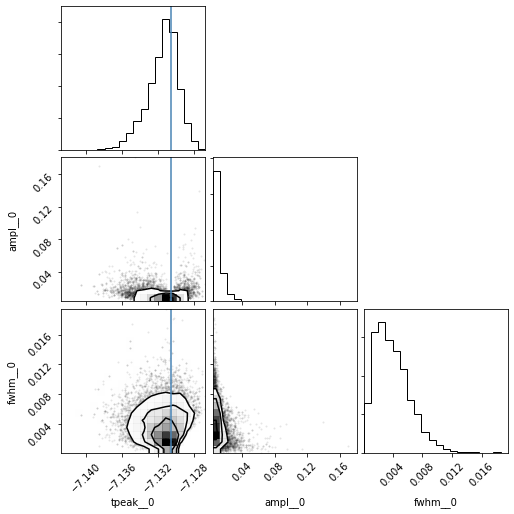

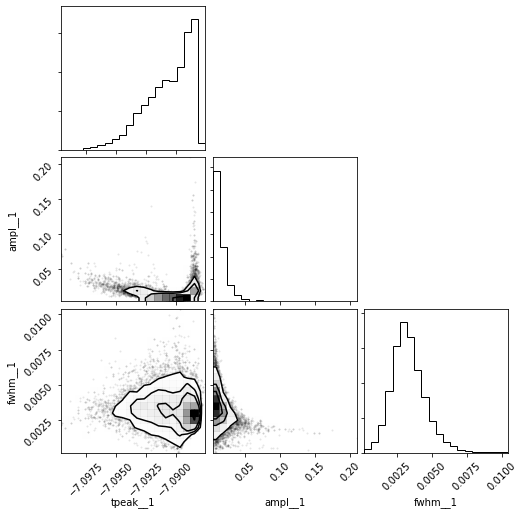

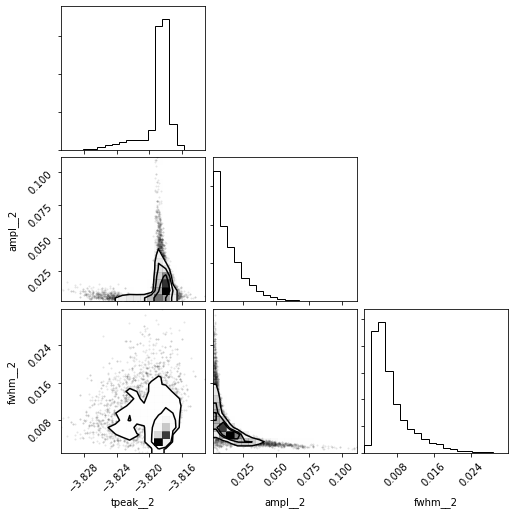

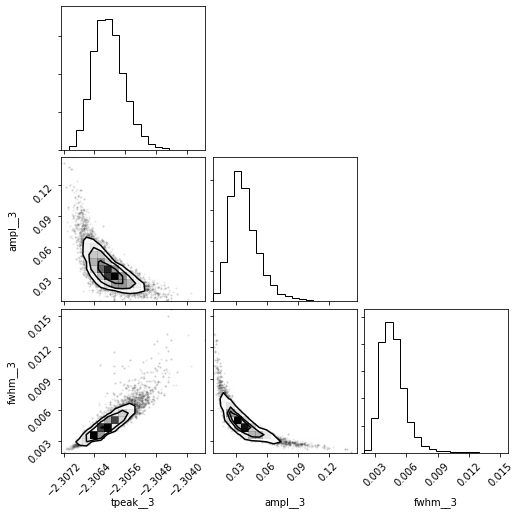

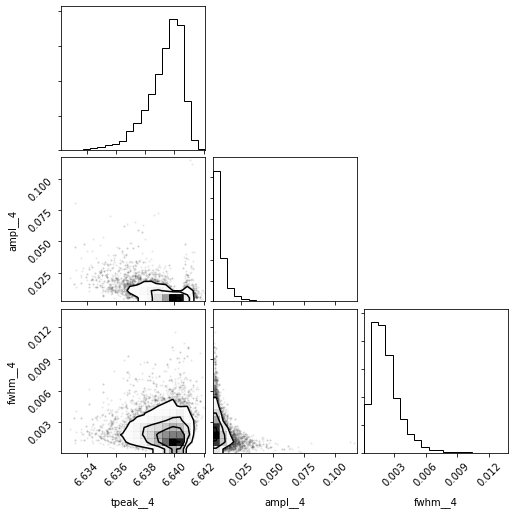

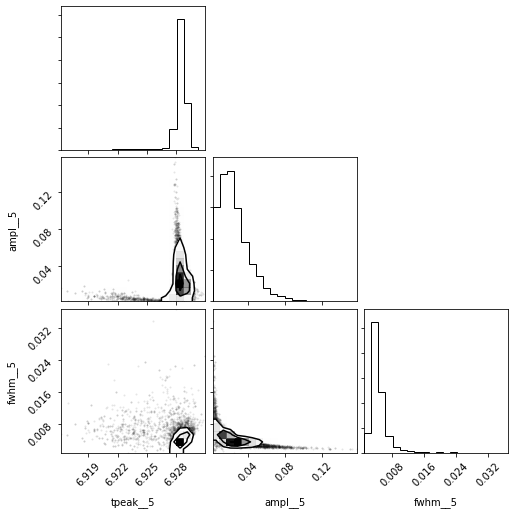

In [64]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

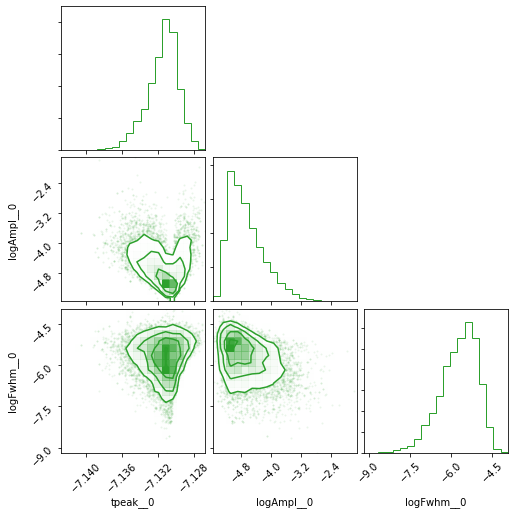

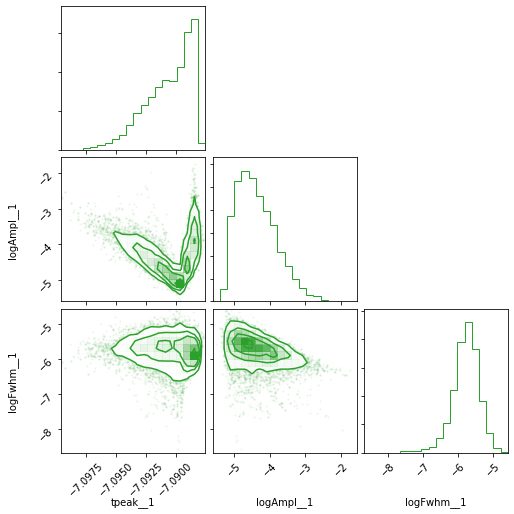

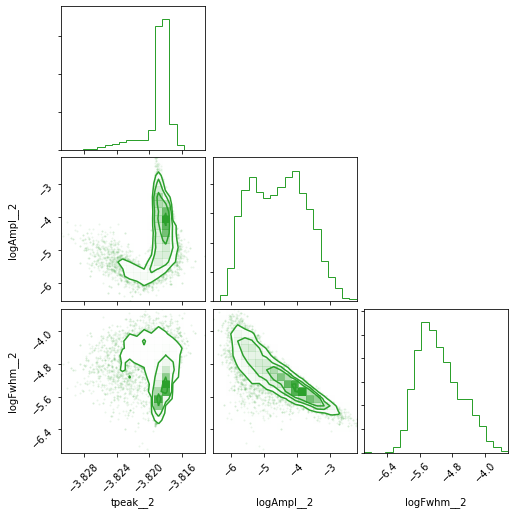

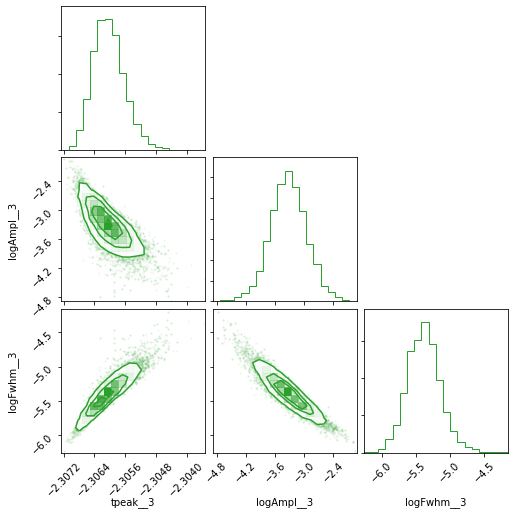

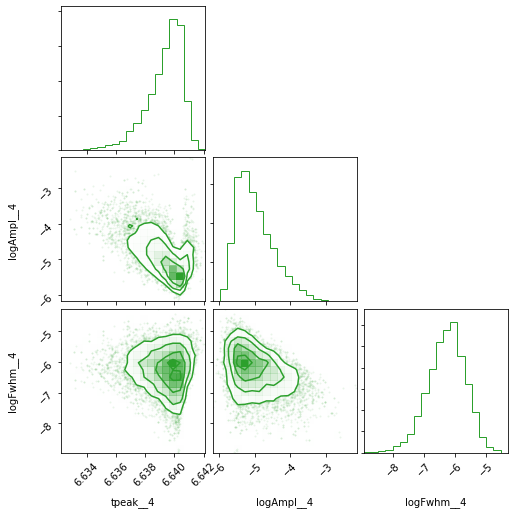

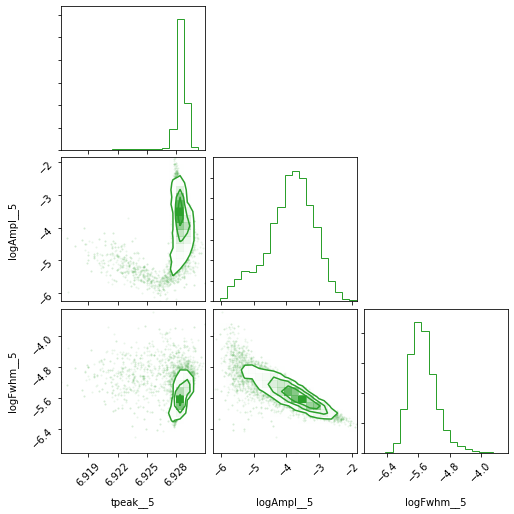

In [65]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

### Flare energies

In [67]:
# get equivalent durations
ed_model = []
for i in range(npeaks-1):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    
print(ed_model)

[31.329305675943896, 8.616888066327727, 16.35704095592714, 9.649478403551212, 9.614004350694643]


In [68]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    parallax = 21.6345 # in milliarcsecs (mas)
    distance = 22.74 # 46.22
    distance = 1./(parallax*0.001) # parsecs
    print(distance)
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
print("log flare energy: ", flare_energies)

46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [31.329305675943896, 8.616888066327727, 16.35704095592714, 9.649478403551212, 9.614004350694643]
log flare energy:  [32.5870972  32.02649688 32.30485117 32.07565027 32.07405075]


In [42]:
"""
# tryna get tpeaks back in units of MJD
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    print(fidx)
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            elif fidx[i+1] - fidx[i] < 3:
                # specifically to deal with a flare that gets double counted because it has a dimple or something
                fidx = np.delete(fidx, i+1)
                n = 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    print(tpeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(post)
"""

[10, 12, 172, 173, 246, 247, 684, 698]
[2938.64037271 2941.95029121 2943.46222768 2952.41124125 2952.69728255]


/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
